In [1]:
import os
import glob
import random

import torch
import numpy as np
import torchvision
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
import torch.nn.functional as F

from IPython.display import Image

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

In [3]:
DATA_PATH = r'D:\HLvL\1_sem_master\AI_kirillov\6000+_Store_Items_Images_Classified_By_Color\train'
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

class ColorDataset(Dataset):
    
    def __init__(self, rootdir, transform) -> None:
        super().__init__()
        self.class_names = os.listdir(rootdir)
        self.class_idx = [i for i in range(len(self.class_names))]
        self.transform = transform
        self.images_pathes = []
        self.images_clas_names = []

        for cls_name in self.class_names:
            sub_root = os.path.join(rootdir, cls_name)
            self.images_pathes.extend(glob.glob(os.path.join(sub_root, '*.jpg')))
            self.images_clas_names.append(cls_name)

        random.shuffle(self.images_pathes)
            
    def __len__(self):
        return len(self.images_pathes)
    
    def __getitem__(self, index) -> tuple:

        img_path = self.images_pathes[index]
        image = cv2.imread(img_path)
        # img_shape = image.shape
        # image = np.reshape(image, (img_shape[-1], img_shape[0], img_shape[1]))
        img_folder_pth = os.path.split(img_path)[0]
        cls_name = os.path.split(img_folder_pth)[-1]
        label = self.class_names.index(cls_name)
        
        if self.transform:
            image = self.transform(image)

        return (image, label)

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize(mean = 0.5, std = 0.5)
    ]
)

Сейчас датасет костылями сделан через разделение руками. Можно сделать через сплит датасета функцией. 

In [5]:
batch_size = 64
dataset = ColorDataset(DATA_PATH, transform)
train_loader = DataLoader(dataset, batch_size=batch_size)

TEST_DATA_PATH = r'D:\HLvL\1_sem_master\AI_kirillov\6000+_Store_Items_Images_Classified_By_Color\test'
test_dataset = ColorDataset(TEST_DATA_PATH, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [6]:
for x,y in train_loader:
    print(x.shape)
    print(y)
    break

torch.Size([64, 3, 224, 224])
tensor([ 1,  2,  9,  4,  6,  7,  2,  9,  8,  6,  3,  2,  1, 11,  8,  4,  4,  8,
         2,  7,  8,  1, 10, 10,  4, 10,  5,  8,  9,  0,  7,  2, 10,  2,  1,  3,
         5, 11,  2,  0,  6,  4,  3,  1,  1,  3,  3,  8,  8,  3,  3,  3,  1,  0,
         8,  4, 10, 10,  3,  8,  9,  4,  1, 11])


In [7]:
# выход с последнего слоя
len(classes.values())       

12

![title](\imgs\lenet.jpg)
![title](\imgs\lenettble.jpg)

In [8]:
class ColorClassificator(nn.Module):
    def __init__(self):
        super(ColorClassificator, self).__init__()
        self.conv_1 = nn.Conv2d(3, 8, (3,3), 1)
        self.conv_2 = nn.Conv2d(8, 8, (3,3), 1)
        self.avPoll_1 = nn.AvgPool2d((2,2), 2)
        self.conv_3 = nn.Conv2d(8, 16, (3,3), 1)
        self.conv_4 = nn.Conv2d(16, 16, (3,3), 1)
        self.avPoll_2 = nn.AvgPool2d((2,2), 2)
        self.conv_5 = nn.Conv2d(16, 32, (3,3), 1)
        self.conv_6 = nn.Conv2d(32, 32, (3,3), 1)
        self.avPoll_3 = nn.AvgPool2d((2,2), 2)
        self.linear_1 = nn.Linear(2592, 512)
        self.linear_2 = nn.Linear(512, 131)


    def forward(self, x):

        x = self.conv_1(x)
        x = self.conv_2(x)
        x = F.tanh(x)
        x = self.avPoll_1(x)
        x = F.tanh(x)

        x = self.conv_3(x)
        x = self.conv_4(x)
        x = F.tanh(x)
        x = self.avPoll_2(x)
        x = F.tanh(x)

        x = self.conv_5(x)
        x = self.conv_6(x)
        x = F.tanh(x)
        x = self.avPoll_3(x)
        x = F.tanh(x)

        x = torch.flatten(x, start_dim=1)

        x = self.linear_1(x)
        x = F.tanh(x)
        x = self.linear_2(x)
        
        return x

In [9]:
model = ColorClassificator()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()

optimizator = torch.optim.Adam(model.parameters(), lr=0.001,)

In [10]:
def val(model, test_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in test_loader:
        y = y.to(device)
        pred = torch.argmax(model(x.to(device)), dim=1)
        tp += int((pred == y).sum().to('cpu'))
        total +=len(pred)
    
    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    for ep in range(epoch):
        for step, (x, y) in enumerate(dataloader):

            y_pred = model(x.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*batch_size
                print(f"loss = {loss}, samples = {current}")

        acc = val(model, test_loader)
        print('accuracy', acc)

        torch.save(model, f'color_classifaer_{epoch}_{acc}.pt')


In [11]:
train(train_loader, model, loss_function, optimizator, 5)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x18432 and 2592x512)

In [ ]:
torch.save(model, 'color_classifaer_5_0.9295.pt')

In [ ]:
model(x).size()

torch.Size([16, 131])

In [ ]:
model.eval()

FruitClassificator(
  (conv_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (avPoll_1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv_3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (avPoll_2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv_5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (avPoll_3): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (linear_1): Linear(in_features=2592, out_features=512, bias=True)
  (linear_2): Linear(in_features=512, out_features=131, bias=True)
)

In [ ]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model(x.to(device)), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))


c:\Users\Sky\anaconda3\lib\site-packages\torch\nn\functional.py:1906: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


355


In [ ]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))


In [ ]:
cm.shape

(131, 131)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(100, 80))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

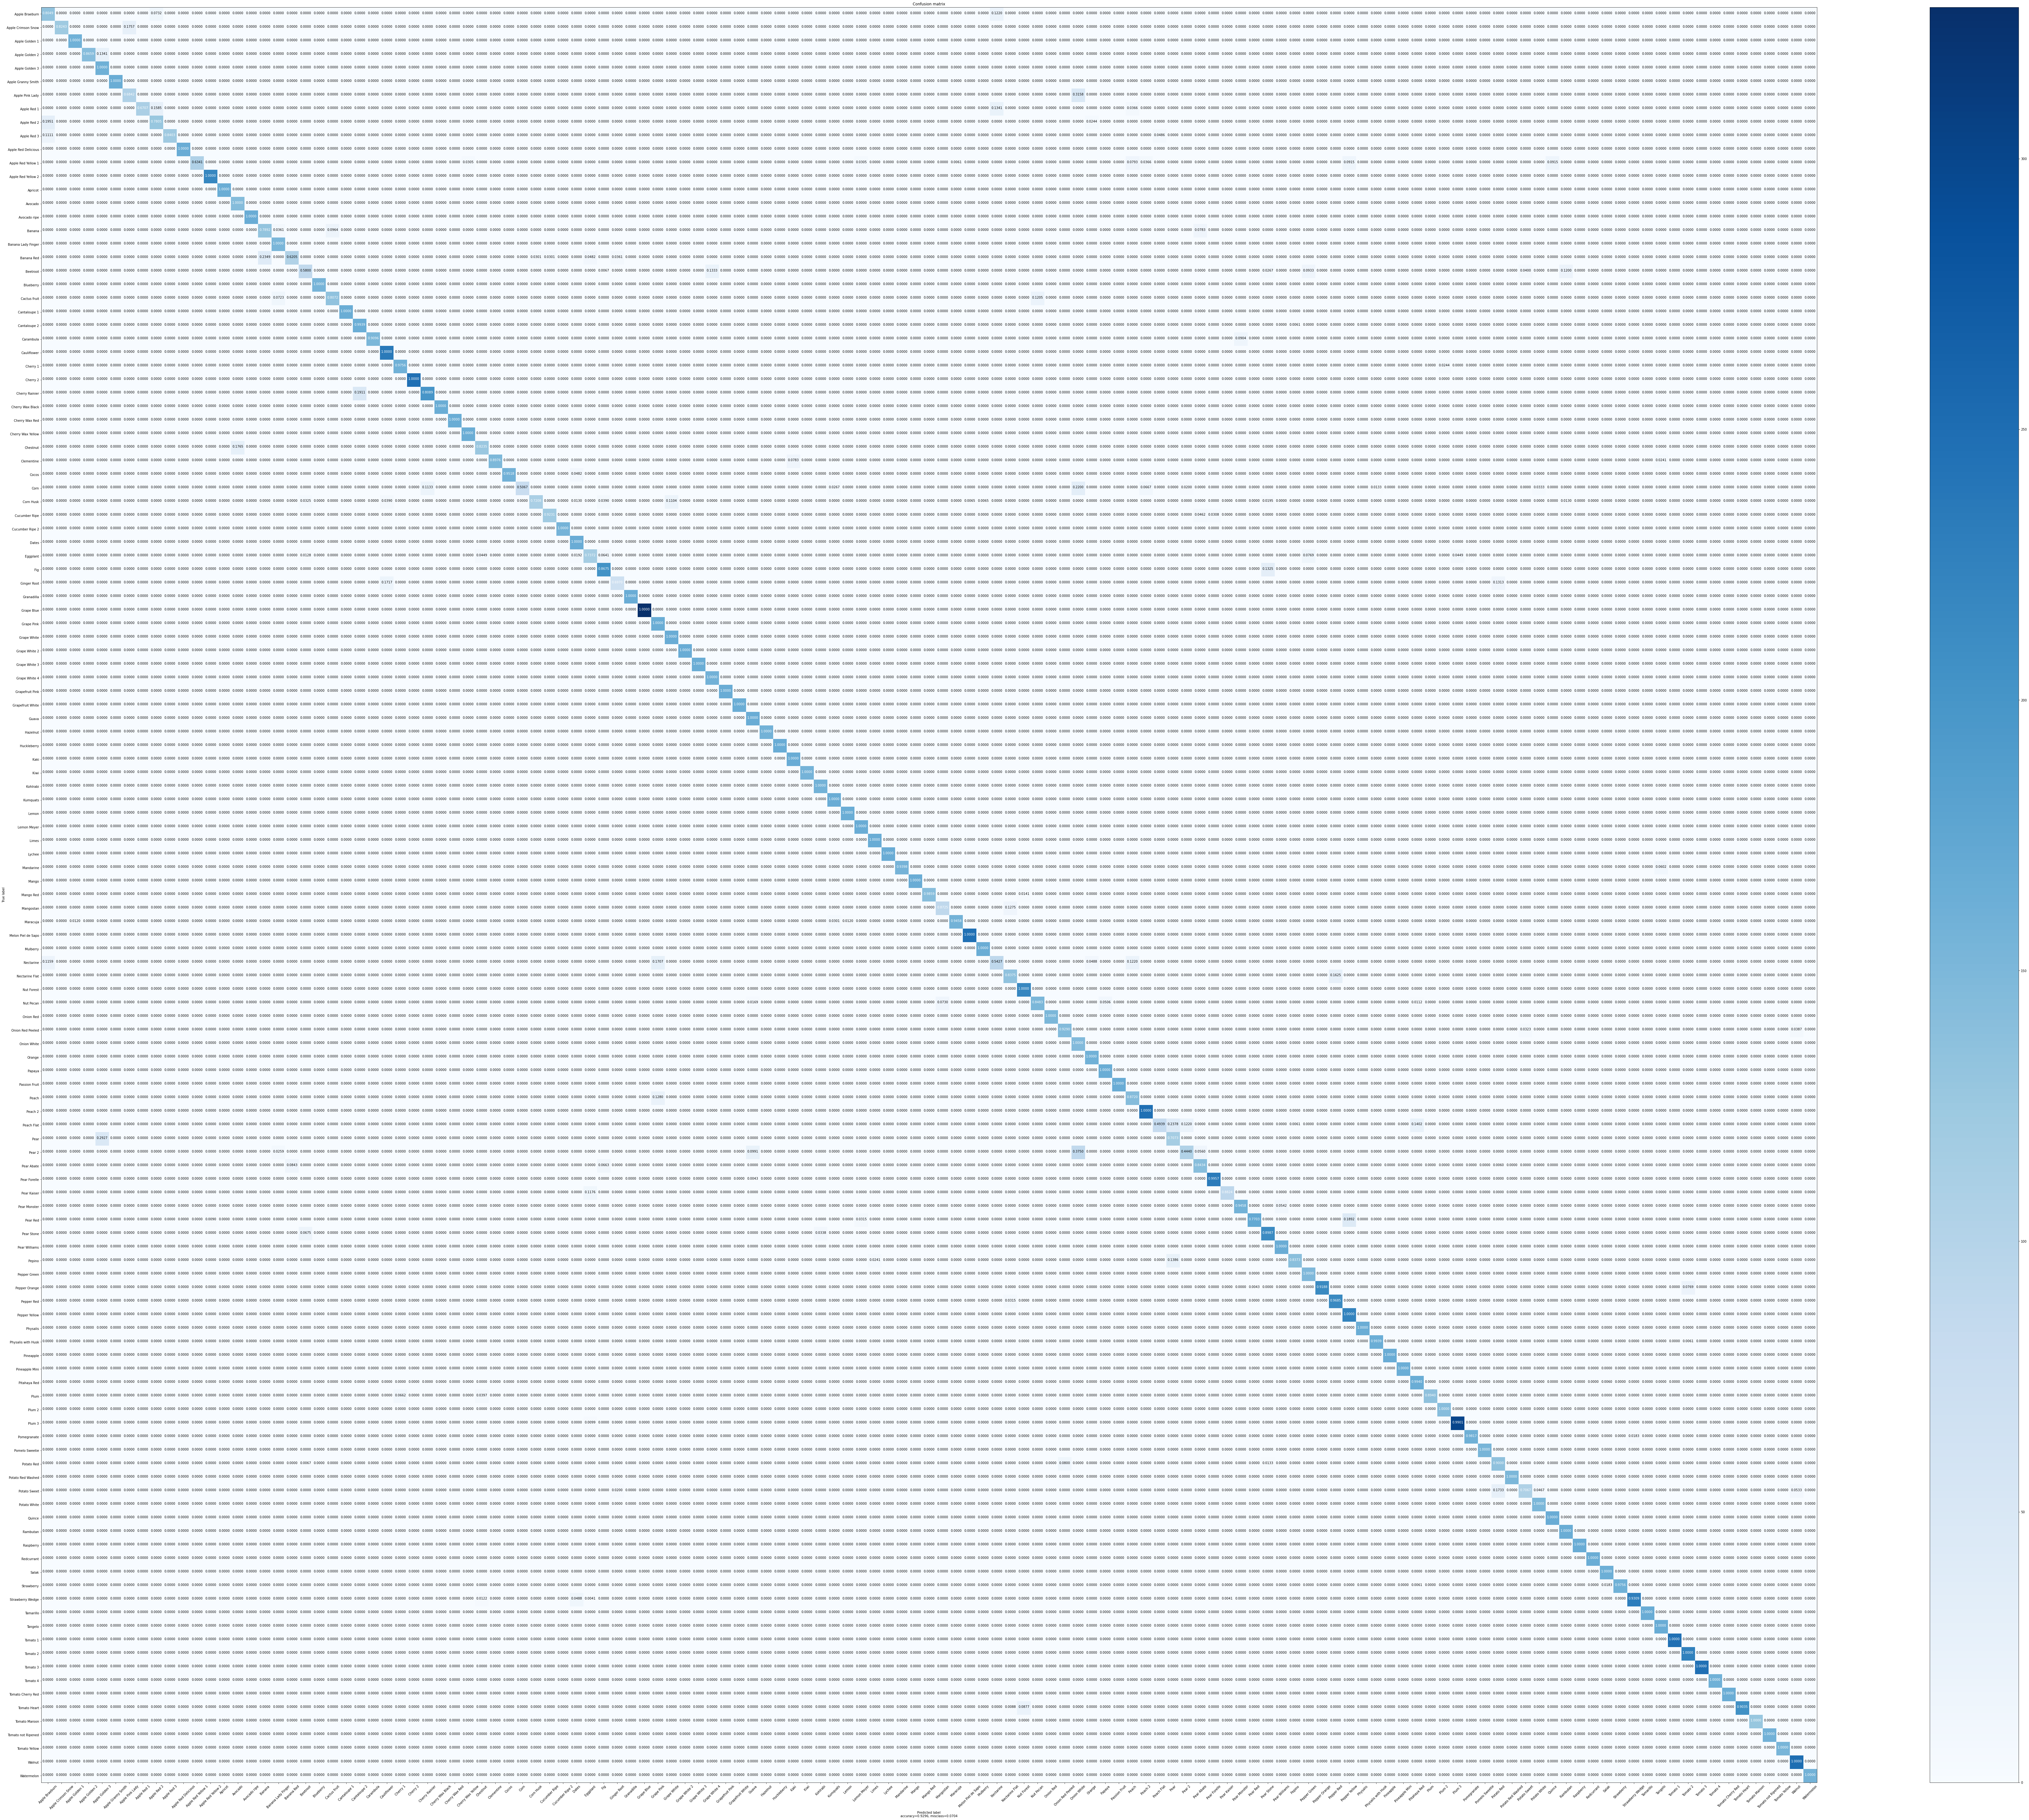

In [ ]:
plot_confusion_matrix(cm, tuple(classes.values()))

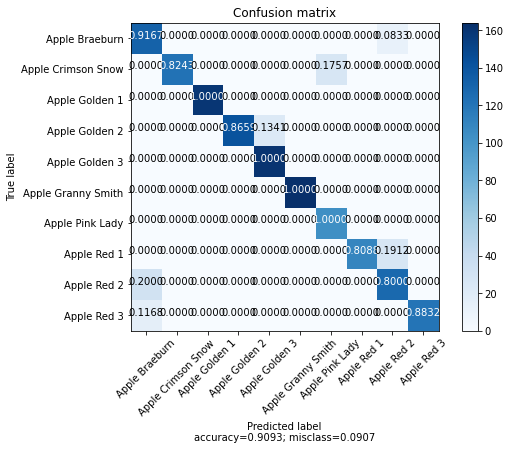

In [ ]:
plot_confusion_matrix(cm[:10,:10], tuple(classes.values())[:10])

<Figure size 14400x14400 with 0 Axes>

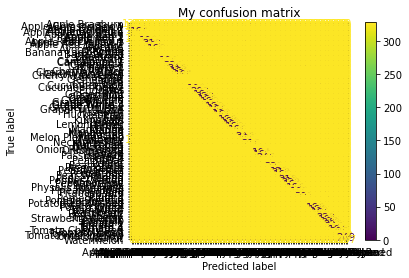

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(200,200))
cm = confusion_matrix(labels, predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuple(classes.values()))
disp.plot()
plt.title("My confusion matrix")
plt.show()